# CMSC 197 - Special Topics (Machine Learning)
## MP3: Naive Bayes Spam Filter
Submitted by: Kristina V. Celis 

Github Link: <https://github.com/tinapayy/CMSC-197>

In [11]:
# IMPORTS
### standard libraries ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### preprocessing ###
import os
import re
from collections import Counter
import email

### performance evaluation plot ###
from sklearn.metrics import confusion_matrix
import seaborn as sns


## Preprocessing 

We will preprocess the email data by cleaning the text, removing non-alphabetic characters, stop words, and creating a dictionary of the 10,000 most frequent words. We will also then split the dataset into training and testing sets ( 3 groups: ham training set, spam training set, and testing set)


In [14]:
# Initialize main dataframe

main_df = pd.DataFrame(columns=["folder", "file", "email_message", "category"])
main_df

,folder,file,email_message,category


In [15]:
# Temporary df for storing labels
labels_path = "trec06p-cs280/labels"

labels_df = pd.read_csv(labels_path, sep=" ", header=None)
labels_df.columns = ["category", "file_path"]

# Change ham/spam to 0/1
labels_df["category"] = labels_df["category"].apply(lambda x: 0 if x == "ham" else 1)
# Remove "../data/" from file_path
labels_df["file_path"] = labels_df["file_path"].apply(lambda x: x.replace("../data/", ""))

# Show df
labels_df

,category,file_path
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [16]:
folder_path = "trec06p-cs280/data/"
folders = os.listdir(folder_path)
folders

['.DS_Store',
 '000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '

In [17]:
# Useless info to be removed from the email
stop_words = []
punctuations = r"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
numbers = "0123456789"
html_tags = re.compile(r"<.*?>")  # remove HTML tags
esc_chars = re.compile(r"[a-z][a-z][0-9]+")  # remove escape characters

# Load the stop words
with open("stop_words.txt", "r") as f:
    stop_word = f.read().splitlines()
    stop_words = [word for word in stop_word]

In [18]:
def clean_email(message):
    # Convert to lowercase
    message = message.lower()
    # Remove HTML tags
    message = re.sub(html_tags, '', message)
    # Remove symbols (punctuations)
    message = message.translate(str.maketrans('', '', punctuations))
    # Remove numbers
    message = message.translate(str.maketrans('', '', numbers))
    # Remove escape characters
    message = re.sub(esc_chars, '', message)
    # Remove non-alphabetic characters
    message = re.sub(r'[^a-zA-Z\s]', '', message)

    # Remove stop words
    words = message.split()
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned message
    message = " ".join(words)
    
    return message

In [19]:
# Function to get message from parsed email
def get_message(parsed):
    message = ""
    # If email has attachments, etc.,
    if parsed.is_multipart():
        # Iterate over parts of the email
        for part in parsed.walk():
            # If the content type of the part is text/plain,
            if part.get_content_type() == 'text/plain':
                # Get message
                message = part.get_payload()
                break
    # else, just get the message
    else:
        message = parsed.get_payload()
    return message

Preprocessed the emails in a standard charset (ISO-8859-1), and cleaned the emails so that all data will be preserved regardless of encoding.

In [21]:
# Get all folders except hidden/system files
folders = [folder for folder in os.listdir(folder_path) if not folder.startswith('.')]

# Loop through the filtered folders
for folder in folders:
    # Get all files in the folder, excluding hidden/system files like .DS_Store
    files = [file for file in os.listdir(f"{folder_path}/{folder}") if not file.startswith('.')]
    
    for file in files:
        # Process each email file
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
             # Read email file
            read_email = e_mail.read()
            # Parse email
            parsed_email = email.message_from_string(read_email)
            # Get message
            message = get_message(parsed_email)
            # Remove useless information
            message_no_stopwords = clean_email(message)
            # Get the category of the email based on the labels df
            category_label = labels_df[labels_df["file_path"] == f"{folder}/{file}"]["category"].values[0]
            # Concatenate the data to the df_main
            main_df = pd.concat([main_df, pd.DataFrame([[folder, file, message_no_stopwords, category_label]], columns=["folder", "file", "email_message", "category"])], ignore_index=True)
# Show the main dataframe
main_df

,folder,file,email_message,category
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1
37818,126,018,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,019,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,020,prosperous future increased money earning powe...,1


Create a folder and store the preprocessed files as a .csv

In [23]:
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')

# Save main_df as preprocessed_emails.csv
main_df.to_csv("preprocessed_files/preprocessed_emails.csv", index = False)

# Reset the main df to avoid memory overload
main_df.drop(main_df.index, inplace = True)
main_df = pd.DataFrame(columns = ["folder", "file", "email_message", "category"])
main_df

,folder,file,email_message,category


In [24]:
# Load the preprocessed dataset
df_main = pd.read_csv("./preprocessed_files/preprocessed_emails.csv")

# Split the dataset into training and testing sets
train_df = df_main[df_main['folder'] <= 70] #Folders 0-70: Train Set
test_df = df_main[df_main['folder'] > 70] #Folders 71-126: Test Set

# Split training to spam and ham
train_spam_df = train_df[train_df['category'] == 1]
train_ham_df = train_df[train_df['category'] == 0]

In [25]:
df_main

,folder,file,email_message,category
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


In [26]:
train_spam_df

,folder,file,email_message,category
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,chauncey conferred luscious continued tonsillitis,1
7,0,7,nbc today body diet beaches magazines hollywoo...,1
8,0,8,oil sector going crazy weekly gift kkpt thing ...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [27]:
train_ham_df

,folder,file,email_message,category
0,0,0,mailing list queried weeks ago running set arc...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,quiet quiet well straw poll plan running,0
6,0,6,working departed totally bell labs recommended...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
21270,70,270,equation generate prime numbers equation theor...,0
21271,70,271,equation generate prime numbers equation theor...,0
21288,70,288,dear dmdx users guidance generating dmdx item ...,0
21293,70,293,built handyboard works great testmotor passes ...,0


In [28]:
test_df

,folder,file,email_message,category
21300,71,0,hesitantly derive perverse satisfaction clodho...,1
21301,71,1,things perform experiment display will remain ...,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
21304,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


To limit the cardinality 
of the dictionary, we can extract only the 10000 most common words

In [30]:
# Initialize a Counter object to keep track of word frequencies
word_counter = Counter()

# Iterate over the df and update the word counts
for email_message in train_df['email_message'].astype(str):
    word_counter.update(email_message.split())

sorted_words = dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))

# Get the top 10000 most common words
top_10000_words = dict(word_counter.most_common(10000))

# Create a list of the top 10000 words for future use
top_10000_words_list = list(top_10000_words.keys())

top_10000_words

{'bb': 16752,
 'will': 11325,
 'board': 5169,
 'company': 4523,
 'price': 4497,
 'gold': 4252,
 'email': 4092,
 'list': 3950,
 'adobe': 3913,
 'time': 3830,
 'nil': 3830,
 'help': 3801,
 'send': 3655,
 'message': 3613,
 'dont': 3574,
 'subject': 3568,
 'crustl': 3295,
 'received': 3093,
 'program': 3081,
 'windows': 2867,
 'work': 2782,
 'professional': 2782,
 'wrote': 2688,
 'well': 2650,
 'ms': 2599,
 'good': 2498,
 'china': 2484,
 'number': 2463,
 'university': 2442,
 'problem': 2361,
 'file': 2247,
 'office': 2247,
 'stock': 2243,
 'handyboard': 2231,
 'hb': 2190,
 'bit': 2188,
 'de': 2170,
 'corp': 2142,
 'info': 2135,
 'microsoft': 2128,
 'current': 2083,
 'add': 2062,
 'studies': 2004,
 'pro': 2000,
 'contenttype': 1973,
 'news': 1971,
 'code': 1952,
 'development': 1936,
 'find': 1927,
 'womens': 1888,
 'great': 1855,
 'people': 1846,
 'today': 1804,
 'read': 1797,
 'best': 1797,
 'system': 1775,
 'save': 1758,
 'power': 1753,
 'motor': 1746,
 'call': 1737,
 'ic': 1727,
 'fax':

## Creating the feature matrices

In [33]:
# Create feature matrix helper function
def create_feature_matrix(df, top_words_list, text_column='email_message'):
    # Create a dictionary for fast word-to-index lookups
    word_to_index = {word: idx for idx, word in enumerate(top_words_list)}
    
    # Initialize the feature matrix with zeros
    feature_matrix = np.zeros((len(df), len(top_words_list)), dtype=np.int32)
    
    # Populate the feature matrix
    for i, email_message in enumerate(df[text_column].astype(str)):
        words = set(email_message.split())  # Convert to set for faster lookups and prevent duplicates
        for word in words:
            if word in word_to_index:  # Check if the word is in the top words
                feature_matrix[i, word_to_index[word]] = 1  # Set the corresponding column to 1

    return feature_matrix

# Create feature matrices for ham and spam emails
ham_train_matrix = create_feature_matrix(train_ham_df, top_10000_words_list)
spam_train_matrix = create_feature_matrix(train_spam_df, top_10000_words_list)

In [34]:
ham_train_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
spam_train_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Computing the Priors

The prior probabilities for spam and ham are computed by the ff formula:

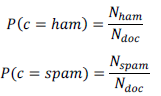

In [39]:
# Num of ham emails in the training set
n_ham = len(train_ham_df)
# Num of spam emails in the training set
n_spam = len(train_spam_df)
# Total number of emails
n_doc = len(train_df)

# Formulas
p_ham = n_ham/n_doc
p_spam = n_spam/n_doc

print(f"P(c = ham) = {p_ham}")
print(f"P(c = spam) = {p_spam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


## Computing the Likelihood of each word

To avoid zero probabilities for words not present in the training data, we will use Laplace smoothing with a smoothing factor `λ=1`.


In [42]:
lambda_smoothing = 1

# Calculate likelihood for each word given ham/spam
def calculate_likelihoods_with_laplace(matrix, vocabulary_size, lambda_smoothing):
    word_counts = np.sum(matrix, axis=0)
    total_count = np.sum(word_counts)
    likelihoods = (word_counts + lambda_smoothing) / (total_count + lambda_smoothing * vocabulary_size)
    return likelihoods

# Likelihood of each word given spam and ham
likelihood_spam = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_smoothing)
likelihood_ham = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_smoothing)

# Print the word probabilities for spam and ham
print(f"Spam word probabilities:\n {likelihood_spam}")
print(f"Ham word probabilities: \n {likelihood_ham}")

Spam word probabilities:
 [2.37470404e-03 5.13897151e-03 1.04272368e-03 ... 2.33271516e-06
 1.63290061e-05 4.66543033e-06]
Ham word probabilities: 
 [4.81217802e-05 6.16226130e-03 5.39231281e-03 ... 1.87140256e-05
 2.40608901e-05 3.74280513e-05]


## Classifying the emails

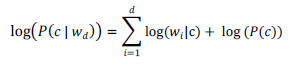

In [89]:
# Classifier Function
def classify_email(email, spam_word_probs, ham_word_probs, p_spam, p_ham):
    # Initialize the log probabilities
    classify_spam = 0
    classify_ham = 0
    
    # Split the email
    email_words = str(email).split()
    
    # Compute the log probability of each
    for word in email_words:
        if word in top_10000_words:
            i = top_10000_words_list.index(word)
            classify_spam += np.log(spam_word_probs[i])
            classify_ham += np.log(ham_word_probs[i])
    
    # Add the log probability of spam and ham
    classify_spam += np.log(p_spam)
    classify_ham += np.log(p_ham)
    
    # Return the class with the highest probability
    return 1 if classify_spam > classify_ham else 0

# Classify all emails in the dataset and store the predicted label (1 = spam, 0 = ham)
train_df.loc[:, 'predicted'] = train_df['email_message'].apply(lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham))
train_df

,folder,file,email_message,category,predicted
0,0,0,mailing list queried weeks ago running set arc...,0,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1,1
2,0,2,academic qualifications prestigious nonacc red...,1,1
3,0,3,greetings verify subscription planfans list ch...,0,0
4,0,4,chauncey conferred luscious continued tonsillitis,1,0
...,...,...,...,...,...
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1,1
21296,70,296,special offer adobe video collection adobe pre...,1,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1,1
21298,70,298,mounted isu infrared demodulator hb realised r...,0,0


## Testing the Classifier

In [90]:
# Using the test_df, we will classify the test emails
test_df.loc[:,'predicted'] = test_df['email_message'].apply(lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham))
test_df

,folder,file,email_message,category,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


## Performance Evaluation

Accuracy: 0.9316668684178671 = 93.17%
Precision: 0.976022835394862 = 97.60%
Recall: 0.921239335428828 = 92.12%
F1-Score: 0.9478401478401478 = 94.78%


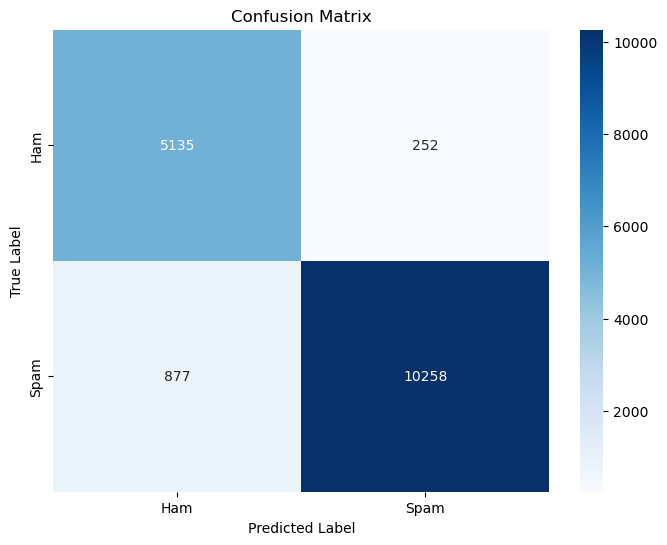

In [170]:
# Define the evaluation function
def evaluate_model(test_df, true_column, predicted_column):
    # Initialize counts for confusion matrix elements
    TP = FP = TN = FN = 0

    # Iterate over the test set and predicted labels
    for index, row in test_df.iterrows():
        true_label = int(row[true_column])  # Assuming 1 for spam and 0 for ham
        predicted_label = int(row[predicted_column])

        if predicted_label == 1 and true_label == 1:
            TP += 1  # True Positive (correctly classified spam emails)
        elif predicted_label == 1 and true_label == 0:
            FP += 1  # False Positive (misclassified ham emails)
        elif predicted_label == 0 and true_label == 0:
            TN += 1  # True Negative (correctly classified ham emails)
        elif predicted_label == 0 and true_label == 1:
            FN += 1  # False Negative (misclassified spam emails)

    # Calculate metrics
    accuracy = (TN + TP) / (TN + TP + FP + FN) if (TN + TP + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Output results
    print(f"Accuracy: {accuracy} = {accuracy * 100:.2f}%")
    print(f"Precision: {precision} = {precision * 100:.2f}%")
    print(f"Recall: {recall} = {recall * 100:.2f}%")
    print(f"F1-Score: {f1_score} = {f1_score * 100:.2f}%")

    # Create an array of actual and predicted categories
    actual = np.array(test_df[true_column])
    predicted = np.array(test_df[predicted_column])

    # Compute the confusion matrix
    matrix = confusion_matrix(actual, predicted, labels=[0, 1])

    # Set up labels for the confusion matrix
    labels = ["Ham", "Spam"]

    # Plot the confusion matrix with better aesthetics
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
        }
# test_df should contain the columns with true and predicted labels
metrics_no_stopwords = evaluate_model(test_df, 'category', 'predicted')

## Results and Discussion

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

I created a **different notebook (with-stopwords.ipynb)** that contains the metric results for the model without removing the stop words in the dataset. So, I will just manually enter here the values that were already computed.

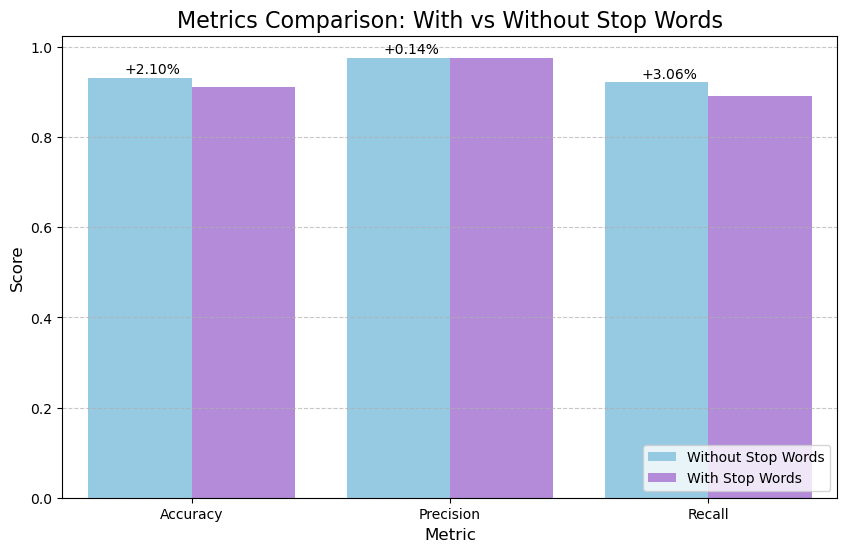

In [53]:
colors = ['#89CFF0', '#b47ee5']

# Create a df for the metrics
metrics_w_stopwords = {
    'Accuracy': 0.9106645684541823,   
    'Precision': 0.9746437346437347,      
    'Recall': 0.8906151773686574      
}

metrics_wo_stopwords = {
    'Accuracy': 0.9316668684178671,   
    'Precision': 0.976022835394862,      
    'Recall': 0.921239335428828     
}

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Without Stop Words': [metrics_wo_stopwords['Accuracy'], metrics_wo_stopwords['Precision'], metrics_wo_stopwords['Recall']],
    'With Stop Words': [metrics_w_stopwords['Accuracy'], metrics_w_stopwords['Precision'], metrics_w_stopwords['Recall']]
})

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars='Metric', var_name='Condition', value_name='Value')

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Condition', data=metrics_melted, palette=colors)

# Add titles and labels
plt.title('Metrics Comparison: With vs Without Stop Words', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(loc='lower right')


# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the difference between the two conditions
for index, row in metrics_df.iterrows():
    diff = row['Without Stop Words'] - row['With Stop Words']
    plt.text(index - 0.15, row['Without Stop Words'] + 0.01, f"+{diff:.2%}", color='black', ha="center", fontsize=10)

# Show plot
plt.show()

It is evident that removing stopwords improved the model's performance across the metrics, since removing non-informative words made it focus more on meaningful content. This leads to a better spam detection and fewer misclassifications.

2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

In [124]:
# Filter the dictionary by word frequency for different k thresholds
filtered_dict_1000 = {word: idx for idx, (word, count) in enumerate(word_counter.items()) if count > 1000}
filtered_dict_100 = {word: idx for idx, (word, count) in enumerate(word_counter.items()) if count > 100}
filtered_dict_50 = {word: idx for idx, (word, count) in enumerate(word_counter.items()) if count > 50}

# Create lists of the filtered words
filtered_list_1000 = list(filtered_dict_1000.keys())
filtered_list_100 = list(filtered_dict_100.keys())
filtered_list_50 = list(filtered_dict_50.keys())

# Output the number of words for each threshold
print(f"Words with frequency > 1000: {len(filtered_dict_1000)}")
print(f"Words with frequency > 100: {len(filtered_dict_100)}")
print(f"Words with frequency = 50: {len(filtered_dict_50)}")

Words with frequency > 1000: 168
Words with frequency > 100: 2755
Words with frequency = 50: 4833


In [140]:
# Redefine likelihood function to be used with filtered dictionary
def calculate_likelihoods_with_laplace_filtered(matrix, filtered_dict, lambda_smoothing):

    # Initialize likelihoods for the filtered dictionary size
    vocab_size = len(filtered_dict)
    likelihoods = np.zeros(vocab_size)
    
    # Calculate the total word count in the feature matrix (sum over all emails)
    word_counts = np.sum(matrix, axis=0)  # Sum across all rows (emails)
    total_word_count = np.sum(word_counts)  # Total number of words in the entire feature matrix
    
    # Calculate likelihoods with Laplace smoothing for each word in the filtered dictionary
    for i in range (vocab_size):
        likelihoods[i] = (word_counts[i] + lambda_smoothing) / (total_word_count + lambda_smoothing * vocab_size)
        
    return likelihoods

In [148]:
# Redefine the classify function to be used with filtered dictionary
def classify(email, spam_word_probs, ham_word_probs, p_spam, p_ham, filtered_dict, filtered_list):
    # Initialize the log probability of spam and ham
    log_p_spam = 0
    log_p_ham = 0
    
    # Split the email into words
    words = str(email).split()
    
    # Compute the log probability of spam and ham
    for word in words:
        if word in filtered_dict:
            log_p_spam += np.log(spam_word_probs[filtered_list.index(word)])
            log_p_ham += np.log(ham_word_probs[filtered_list.index(word)])
    
    # Add the log probability of spam and ham
    log_p_spam += np.log(p_spam)
    log_p_ham += np.log(p_ham)
    
    # Return the class with the highest log probability
    return 1 if log_p_spam > log_p_ham else 0

In [107]:
print(f"Filtered Dictionary Size (k > 1000): {len(filtered_dict_1000)}")
print(f"Feature Matrix Shape (spam): {spam_train_matrix_1000.shape}")
print(f"Feature Matrix Shape (ham): {ham_train_matrix_1000.shape}")


Filtered Dictionary Size (k > 1000): 168
Feature Matrix Shape (spam): (13777, 168)
Feature Matrix Shape (ham): (7523, 168)


In [136]:
# Create feature matrices for spam and ham emails using the re-indexed filtered dictionaries
spam_train_matrix_1000 = create_feature_matrix(train_spam_df, list(filtered_dict_1000.keys()))
ham_train_matrix_1000 = create_feature_matrix(train_ham_df, list(filtered_dict_1000.keys()))

spam_train_matrix_100 = create_feature_matrix(train_spam_df, list(filtered_dict_100.keys()))
ham_train_matrix_100 = create_feature_matrix(train_ham_df, list(filtered_dict_100.keys()))

spam_train_matrix_50 = create_feature_matrix(train_spam_df, list(filtered_dict_50.keys()))
ham_train_matrix_50 = create_feature_matrix(train_ham_df, list(filtered_dict_50.keys()))


In [150]:
# Calculate likelihoods using Laplace smoothing for each threshold
lambda_smoothing = 1  # Laplace smoothing parameter

# For k > 1000
likelihood_spam_1000 = calculate_likelihoods_with_laplace_filtered(spam_train_matrix_1000, filtered_dict_1000, lambda_smoothing)
likelihood_ham_1000 = calculate_likelihoods_with_laplace_filtered(ham_train_matrix_1000, filtered_dict_1000, lambda_smoothing)

# For k > 100
likelihood_spam_100 = calculate_likelihoods_with_laplace_filtered(spam_train_matrix_100, filtered_dict_100, lambda_smoothing)
likelihood_ham_100 = calculate_likelihoods_with_laplace_filtered(ham_train_matrix_100, filtered_dict_100, lambda_smoothing)

# For k > 50
likelihood_spam_50 = calculate_likelihoods_with_laplace_filtered(spam_train_matrix_50, filtered_dict_50, lambda_smoothing)
likelihood_ham_50 = calculate_likelihoods_with_laplace_filtered(ham_train_matrix_50, filtered_dict_50, lambda_smoothing)

In [156]:
test_df_k = test_df.copy()
test_df_k.drop('predicted', axis=1, inplace=True)
# Classify test emails for k > 1000
test_df_k['predicted_k1000'] = test_df_k['email_message'].apply(
    lambda x: classify(x, likelihood_spam_1000, likelihood_ham_1000, p_spam, p_ham, filtered_dict_1000, filtered_list_1000)
)

# Classify test emails for k > 100
test_df_k['predicted_k100'] = test_df_k['email_message'].apply(
    lambda x: classify(x, likelihood_spam_100, likelihood_ham_100, p_spam, p_ham, filtered_dict_100, filtered_list_100)
)

# Classify test emails for k > 50
test_df_k['predicted_k50'] = test_df_k['email_message'].apply(
    lambda x: classify(x, likelihood_spam_50, likelihood_ham_50, p_spam, p_ham, filtered_dict_50, filtered_list_50)
)

test_df_k

,folder,file,email_message,category,predicted_k1000,predicted_k100,predicted_k50
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1,1,1
21301,71,1,things perform experiment display will remain ...,0,0,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1,1,1
...,...,...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1,1,1
37820,126,20,prosperous future increased money earning powe...,1,1,1,1


Metrics for k > 1000:
Accuracy: 0.9088488076504055 = 90.88%
Precision: 0.9234016357400404 = 92.34%
Recall: 0.9429726088908846 = 94.30%
F1-Score: 0.9330845107971207 = 93.31%


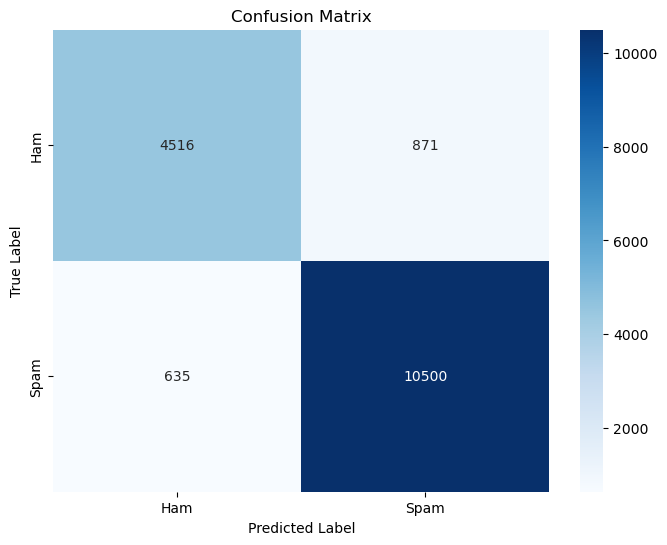

Metrics for k > 100:
Accuracy: 0.929427430093209 = 92.94%
Precision: 0.9716151007663922 = 97.16%
Recall: 0.9222272114952851 = 92.22%
F1-Score: 0.9462771839292295 = 94.63%


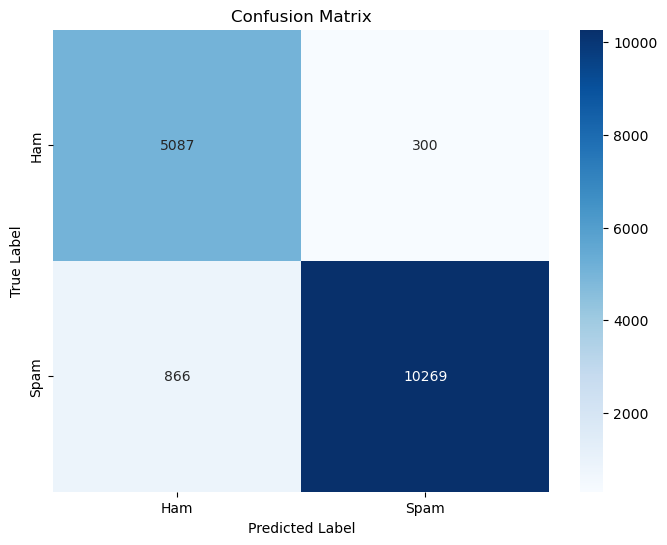

Metrics for k > 50:
Accuracy: 0.9295484808134609 = 92.95%
Precision: 0.9735017570519517 = 97.35%
Recall: 0.9205208801077683 = 92.05%
F1-Score: 0.9462703101920236 = 94.63%


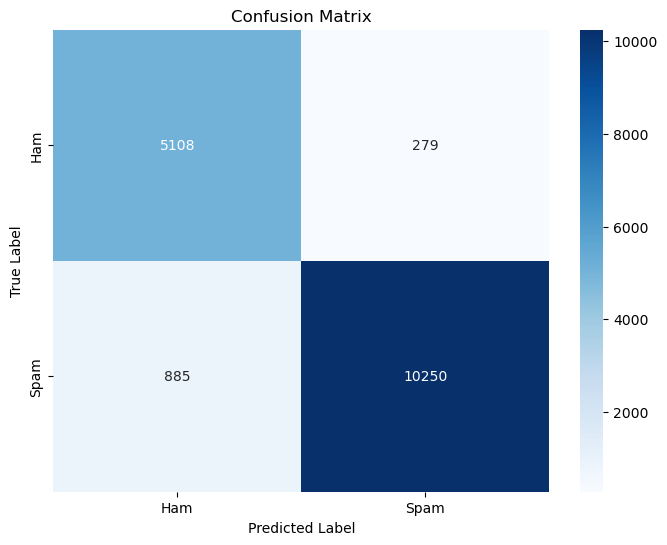

In [166]:
# Evaluate the model for k > 1000
print("Metrics for k > 1000:")
metrics_k1000 = evaluate_model(test_df_k, 'category', 'predicted_k1000')

# Evaluate the model for k > 100
print("Metrics for k > 100:")
metrics_k100 = evaluate_model(test_df_k, 'category', 'predicted_k100')

# Evaluate the model for k > 50
print("Metrics for k > 50:")
metrics_k50 = evaluate_model(test_df_k, 'category', 'predicted_k50')


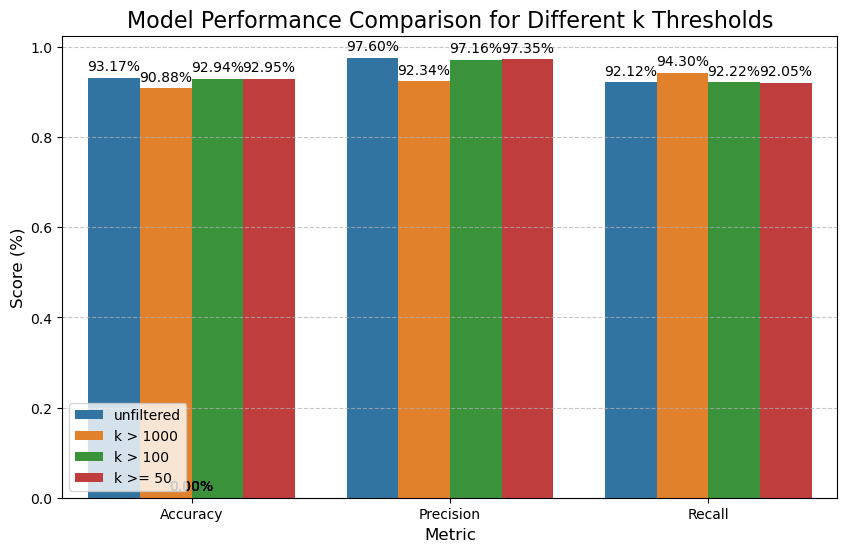

In [203]:
# Store the metrics in a dictionary for comparison
metrics_comparison = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'unfiltered': [metrics_no_stopwords['Accuracy'], metrics_no_stopwords['Precision'], metrics_no_stopwords['Recall']],
    'k > 1000': [metrics_k1000['Accuracy'], metrics_k1000['Precision'], metrics_k1000['Recall']],
    'k > 100': [metrics_k100['Accuracy'], metrics_k100['Precision'], metrics_k100['Recall']],
    'k >= 50': [metrics_k50['Accuracy'], metrics_k50['Precision'], metrics_k50['Recall']]
}

# Convert the dictionary to a pandas df
metrics_df = pd.DataFrame(metrics_comparison)
metrics_melted = metrics_df.melt(id_vars='Metric', var_name='Condition', value_name='Value')

plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.barplot(x='Metric', y='Value', hue='Condition', data=metrics_melted)

# Add titles and labels
plt.title('Model Performance Comparison for Different k Thresholds', fontsize=16)
plt.ylabel('Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height() * 100:.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Add grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Move the legend to the best position
plt.legend(loc='lower left')

# Display the plot
plt.show()


The plot shows that the **unfiltered model** performs a bit better in **Accuracy** and **Precision**, but the filtered models (with different word thresholds) still hold up well, especially in **Recall**. So, removing less frequent words doesn't hurt the model much, though it slightly lowers precision.

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

Results for Lambda = 2.0:
Accuracy: 0.9299721583343421 = 93.00%
Precision: 0.9757772267785619 = 97.58%
Recall: 0.918904355635384 = 91.89%
F1-Score: 0.946487211507331 = 94.65%


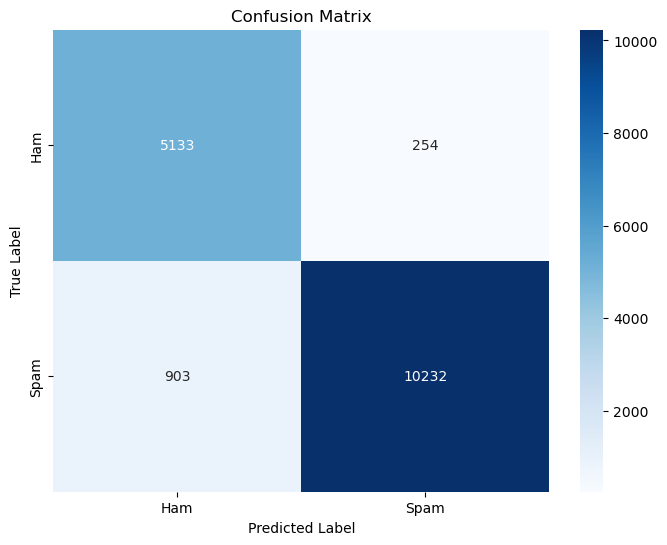

Results for Lambda = 1.0:
Accuracy: 0.9316668684178671 = 93.17%
Precision: 0.976022835394862 = 97.60%
Recall: 0.921239335428828 = 92.12%
F1-Score: 0.9478401478401478 = 94.78%


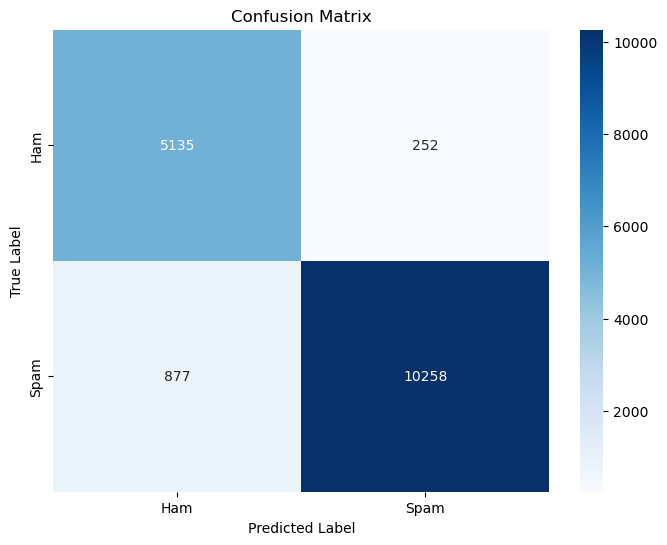

Results for Lambda = 0.5:
Accuracy: 0.9319089698583707 = 93.19%
Precision: 0.9762131303520457 = 97.62%
Recall: 0.921418949259093 = 92.14%
F1-Score: 0.9480249480249481 = 94.80%


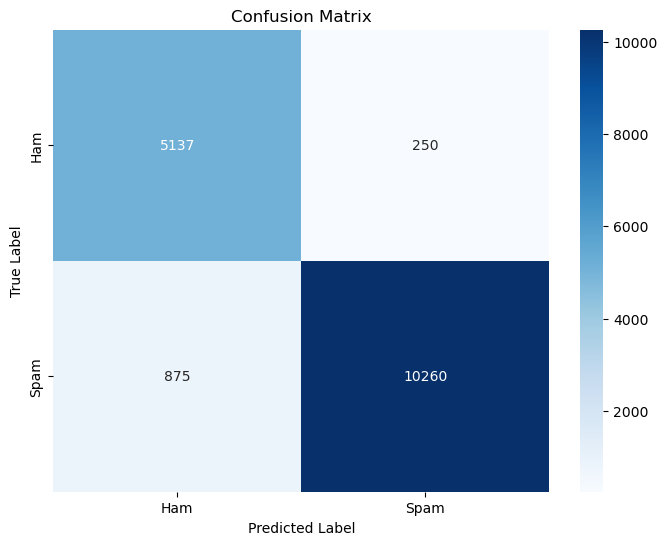

Results for Lambda = 0.1:
Accuracy: 0.932272122019126 = 93.23%
Precision: 0.9766799923853037 = 97.67%
Recall: 0.9215087561742255 = 92.15%
F1-Score: 0.9482925927637355 = 94.83%


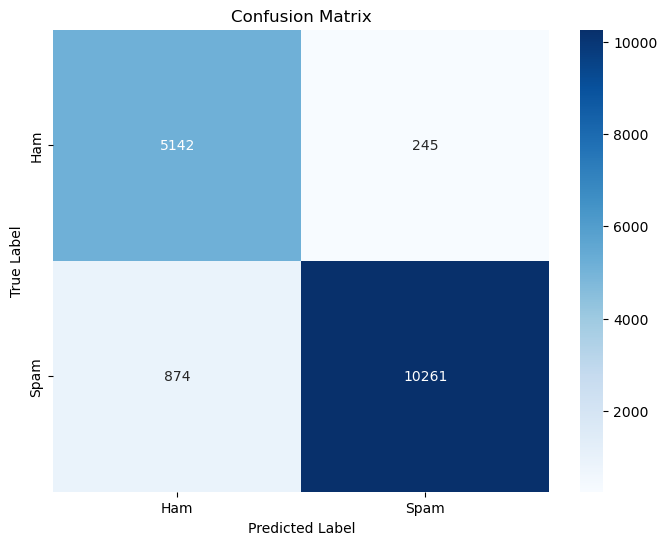

Results for Lambda = 0.005:
Accuracy: 0.9319694952184966 = 93.20%
Precision: 0.977032307252454 = 97.70%
Recall: 0.9207004939380332 = 92.07%
F1-Score: 0.9480303310523395 = 94.80%


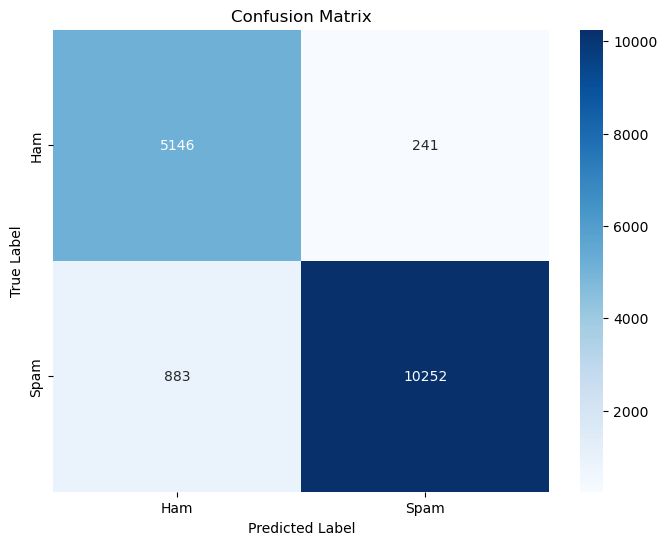

In [209]:
# Define new lambda values to test
lambda_values_new = [2.0, 1.0, 0.5, 0.1, 0.005]

# Dictionary to store results
lambda_results_new = {}

for lambda_val in lambda_values_new:
    test_df_copy = test_df.copy()
    
    # Recalculate likelihoods
    likelihood_spam_lambda = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_val)
    likelihood_ham_lambda = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_val)
    
    # Classify test emails
    test_df_copy[f'predicted_lambda_{lambda_val}'] = test_df_copy['email_message'].apply(
        lambda x: classify_email(x, likelihood_spam_lambda, likelihood_ham_lambda, p_spam, p_ham)
    )
    print(f"Results for Lambda = {lambda_val}:")
    # Evaluate performance metrics
    metrics_lambda = evaluate_model(test_df_copy, 'category', f'predicted_lambda_{lambda_val}')
    
    # Store the metrics
    lambda_results_new[lambda_val] = metrics_lambda

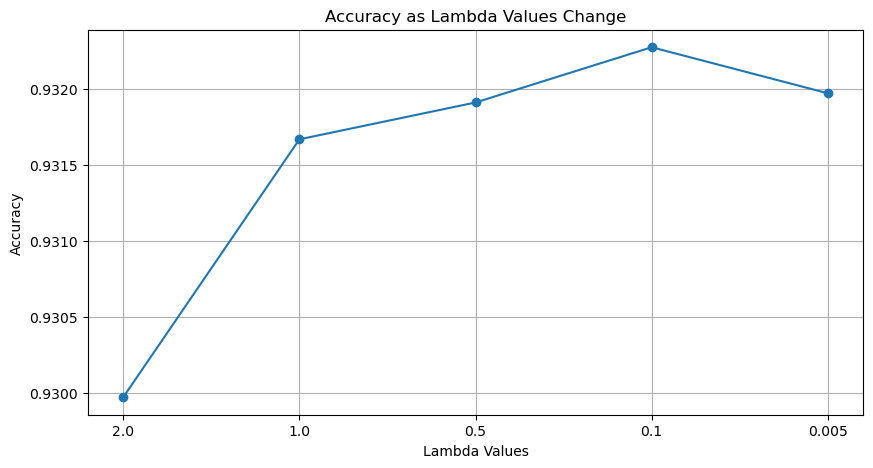

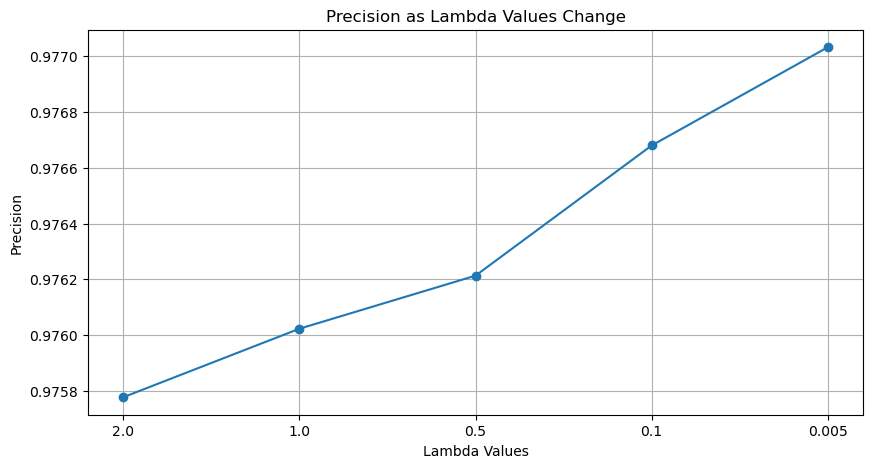

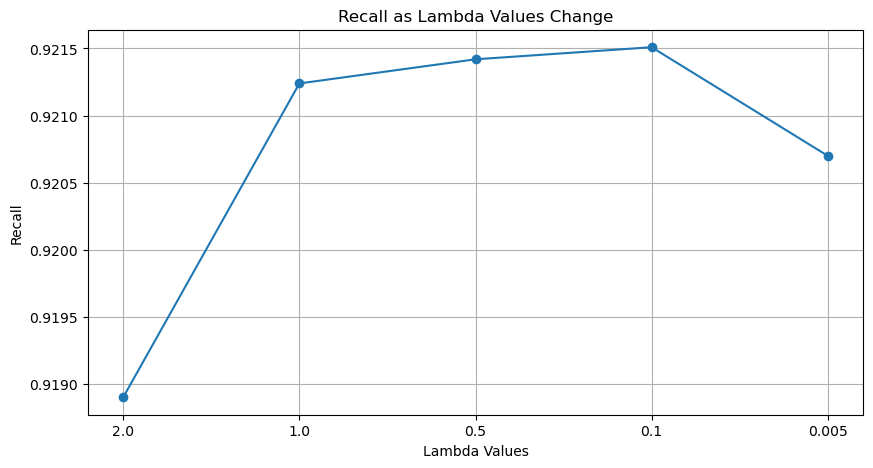

In [211]:
# Lambda values and corresponding metrics from lambda_results_new
lambda_values_labels = ['2.0', '1.0', '0.5', '0.1', '0.005']
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

# Extract Accuracy, Precision, and Recall from lambda_results_new for each lambda
accuracy_lambda_metrics = [lambda_results_new[lambda_val]['Accuracy'] for lambda_val in lambda_values]
precision_lambda_metrics = [lambda_results_new[lambda_val]['Precision'] for lambda_val in lambda_values]
recall_lambda_metrics = [lambda_results_new[lambda_val]['Recall'] for lambda_val in lambda_values]

# Plot of Accuracy as lambda values change
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(lambda_values_labels, accuracy_lambda_metrics, marker='o')
ax.set_title('Accuracy as Lambda Values Change', fontsize=12)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Lambda Values')
plt.grid(True)
plt.show()

# Plot of Precision as lambda values change
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(lambda_values_labels, precision_lambda_metrics, marker='o')
ax.set_title('Precision as Lambda Values Change', fontsize=12)
ax.set_ylabel('Precision')
ax.set_xlabel('Lambda Values')
plt.grid(True)
plt.show()

# Plot of Recall as lambda values change
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(lambda_values_labels, recall_lambda_metrics, marker='o')
ax.set_title('Recall as Lambda Values Change', fontsize=12)
ax.set_ylabel('Recall')
ax.set_xlabel('Lambda Values')
plt.grid(True)
plt.show()


From the line graph, we can see the that when the lambda is around 1.0 or 0.5, the model performs best in terms of accuracy and recall. But as lambda gets smaller (0,005), precision keeps improving, suggesting that smaller values of lambda help the model focus more on correctly identifying relevant spam emails. However, Recall reaches its highest point around lambda = 0.5 and then declines as λ decreases, indicating that while precision improves, the model might start missing more spam emails as lambda decreases. Overall, the intermediate values (around 0,5 to 1.0) provides the best trade-ofs by doing a good job in balancing between identifiying spam and not missing too many.

4. What are your recommendations to further improve the model?

Based on my experience with this problem set, here are some recommendations to improve the model:

General suggestion (because this one was really a headache): Since the notebook took a long time and consumed a lot of resources, we could speed up the preprocessing stages by using stemming instead of lemmatization, or we could reduce the size of the feature set by limiting the number of top words. Furthermore, faster training and testing could be achieved without compromising too much accuracy by streamlining the handling of the data, like employing an efficient algorithm or batch processing. 

Other suggestions:

- Experiment with how stop words are handled, or maybe only eliminate some of them to see if it improves outcome.
- Including bigrams or trigrams (two or three-word phrases) could capture more context from the emails.
- Make sure the dataset is balanced between spam and ham emails so the model doesn't favor one over the other.
- Try filtering out rare words or setting different frequency limits for words to improve feature selection.
- Fine-tune parameters like lambda and the number of top words to see if we can boost the model’s accuracy.